# Capstone Project

### Candidates for research

__Our goal is to find difference between big, medium and small capital cities in the Europe.
From the perspective described in my business problem in report, I have chosen London, Copenhagen
and Vaduz.
This three cities should implicate nice outcome.__

In [1]:
from urllib.request import urlopen
import requests
import re
import math
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__Lets try to find necessarry informations without using specific web scraping libraries__

In [2]:
try:
    london_web = requests.get('https://en.wikipedia.org/wiki/London').text
    copenhagen_web = requests.get('https://en.wikipedia.org/wiki/Copenhagen').text
    vaduz_web = requests.get('https://en.wikipedia.org/wiki/Vaduz').text 
except:
    print('One of the urls is not active or has been permamently moved')

__Thats how London web page looks like in html code, construction in Copenhagen and Vaduz web pages are very similar__

In [3]:
response = urlopen('https://en.wikipedia.org/wiki/London')
data = response.read()
encoding = response.info().get_content_charset()
html = data.decode(encoding)
#print(html)

__All of these three web pages are arranged very similar, so if we find occurrences in one we will also find it in others.__

## Get Data

__Lets find informations about cities.__<br/>
_I added some values at the end of each value of directory as appendix, it will help us to restrict searching_

In [4]:
LONDON_TEXT_DATA = {
    'latitude': london_web.find('latitude') + 10,
    'longitude': london_web.find('longitude') + 10,
    'area': london_web.find('Total') + 129,
    'population': london_web.find('Population') + 242
}

COPENHAGEN_TEXT_DATA = {
    'latitude': copenhagen_web.find('latitude') + 10,
    'longitude': copenhagen_web.find('longitude') + 10,
    'area': copenhagen_web.find('Area') + 295,
    'population': copenhagen_web.find('Population') + 270
}

VADUZ_TEXT_DATA = {
    'latitude': vaduz_web.find('latitude') + 10,
    'longitude': vaduz_web.find('longitude') + 10,
    'area': vaduz_web.find('Total') + 10,
    'population': vaduz_web.find('Population') + 250
}

#### In this three dicts I will hold all informations about there cities

In [5]:
london = {
    'latitude': '',
    'longitude': '',
    'area': '',
    'population': ''
}

copenhagen = {
    'latitude': '',
    'longitude': '',
    'area': '',
    'population': ''
}

vaduz = {
    'latitude': '',
    'longitude': '',
    'area': '',
    'population': ''
}


__Obtaining wiki page in function to fill out dicts__

In [6]:
def scrap(scraped_data, web, TEXT_DATA):
    for letter in range(10):
        scraped_data['latitude'] += web[TEXT_DATA['latitude'] + letter]
        scraped_data['longitude'] += web[TEXT_DATA['longitude'] + letter]
        scraped_data['area'] += web[TEXT_DATA['area'] + letter]
        scraped_data['population'] += web[TEXT_DATA['population'] + letter]
    return scraped_data

In [7]:
london = scrap(london, london_web, LONDON_TEXT_DATA)
copenhagen = scrap(copenhagen, copenhagen_web, COPENHAGEN_TEXT_DATA)
vaduz = scrap(vaduz, vaduz_web, VADUZ_TEXT_DATA)

## Data Cleaning

__Cleaning accquired data from web pages, firstly we have to prepare functions to do it in convinient way.__

In [8]:
def clean_dataset(data):
    for key in data.keys():
        data[key] = re.split(r'[^0-9]', data[key])
        data[key] = list(filter(func, data[key]))
    return data

def func(value):
    if value is '':
        return False
    else:
        return True
    
def location(lst):
    lst[0] += '.'
    return ''.join(lst)

def radius(lst):
    lst[0] += '.'
    area = ''.join(lst)
    
    try:
        area = float(area)
    except ValueError:
        print('area must be digit')

    radius = math.sqrt(area * 1000000/math.pi)
    return str(radius)

def people(lst):
    return ''.join(lst) + '000'

__Now we can clean real data__

In [9]:
def clean(dataset: dict):
    dataset = clean_dataset(dataset)
    dataset['latitude'] = location(dataset['latitude'])
    dataset['longitude'] = location(dataset['longitude'])
    dataset['area'] = radius(dataset['area'])
    dataset['population'] = people(dataset['population'])
    return dataset

london = clean(london)
copenhagen = clean(copenhagen)
vaduz = clean(vaduz)

__How our data sets looks like after complete cleaning__

In [10]:
print(london)
print(copenhagen)
print(vaduz)

{'latitude': '51.3026', 'longitude': '0.739', 'area': '707.3776509622841', 'population': '160160000'}
{'latitude': '55.4034', 'longitude': '12.3406', 'area': '7536.947809847119', 'population': '777218000'}
{'latitude': '47.0828', 'longitude': '9.3116', 'area': '2346.648893844066', 'population': '5521000'}


__Set the centre of radius in the middle of city to avoid mismatches later__

In [11]:
DIFFERENCES = {
    'london': ['51.508530', '-0.076132'],
    'copenhagen': ['55.67594', '12.56553'],
    'vaduz': ['47.14151', '9.52154']
}

def match_scraped_with_real(latitude, longitude, city):
    if latitude != DIFFERENCES[city][0]:
        latitude = DIFFERENCES[city][0]
        
    if longitude != DIFFERENCES[city][1]:
        longitude = DIFFERENCES[city][1]
    
    return latitude, longitude

london['latitude'], london['longitude'] = match_scraped_with_real(london['latitude'], london['longitude'], 'london')
copenhagen['latitude'], copenhagen['longitude'] = match_scraped_with_real(copenhagen['latitude'], copenhagen['longitude'], 'copenhagen')
vaduz['latitude'], vaduz['longitude'] = match_scraped_with_real(vaduz['latitude'], vaduz['longitude'], 'vaduz')

### Foursquare

__We are using Foursquare API to obtain data about restaurants from given datasets__

__Creating url to get json data__ 

In [12]:
CLIENT_ID = 'B55H0AWBELF5VY14BCW4IDKYSZDUMHMKGQCDHN00KTFZ4WA5'
CLIENT_SECRET = 'SKQRP4XEEXIJPLWQOZFPXZKRJIS3VBLGY0XSMRTG2K3ELOOB'
VERSION = '20180605'
CATEGORY = '4d4b7105d754a06374d81259'

def create_url(latitude, longitude, area):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    area,
    CATEGORY
)
    return url


url_london = create_url(london['latitude'], london['longitude'], london['area'])
url_copenhagen = create_url(copenhagen['latitude'], copenhagen['longitude'], copenhagen['area'])
url_vaduz = create_url(vaduz['latitude'], vaduz['longitude'], vaduz['area'])

__Our json files with restaurants data__

In [13]:
london_restaurants = requests.get(url_london).json()
#london_restaurants

In [14]:
copenhagen_restaurants = requests.get(url_copenhagen).json()
#copenhagen_restaurants

In [15]:
vaduz_restaurants = requests.get(url_vaduz).json()
#vaduz_restaurants

## Methodology

In this project, we have __gained data from Wikipedia websites__ to get physical informations about cities which we have chosen.<br/>
The second step is __cleaning__ this data to accquire informations important to us. In this cases creating several functions to deal with it in once are complitely necessarry.<br/>
Next we have to construct __url__ to connect informations scraped from Wiki site and Foursquare API. In the result, we received json files with data.<br/>
We have to __analyze__ that to get this json files into more comfortable format as a pandas __dataframe__ which will contain informations ready to visualize.<br/>
After visualization we will be able to pull out __results__ with significant __conclusions__ at the end.

## Analytics

__The easiest way is to create function to receive data frames from all three cities, because data frames may be vary only in data tuples.__ 

In [16]:
def get_restaurants(url, latitudes, longitudes, radius):
    
    venues_list=[]
    for lat, lng in zip(latitudes, longitudes):

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #print(results)
        # return only relevant information for each nearby venue
        venues_list.append([( 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Restaurant', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category']
    
    return nearby_venues

get_london_restaurants = get_restaurants(url_london, london['latitude'], london['longitude'], london['area'])
get_copenhagen_restaurants = get_restaurants(url_copenhagen, copenhagen['latitude'], copenhagen['longitude'], copenhagen['area'])
get_vaduz_restaurants = get_restaurants(url_vaduz, vaduz['latitude'], vaduz['longitude'], vaduz['area'])

## Visualization

__Firstly let see how much restaurants are in the each city centre.__ 

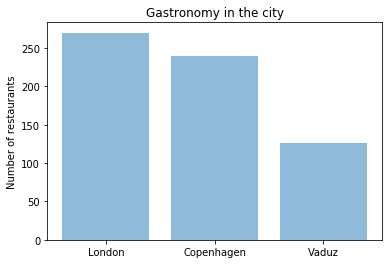

In [17]:
objects = ('London', 'Copenhagen', 'Vaduz')
y_pos = np.arange(len(objects))
count = [get_london_restaurants.shape[0], get_copenhagen_restaurants.shape[0], get_vaduz_restaurants.shape[0]]
 
plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of restaurants')
plt.title('Gastronomy in the city')
 
plt.show()

__Now we can specify our demands to select amount of specific restaurants in the city.__

Text(0.5, 1.0, 'Kind of restaurants in London')

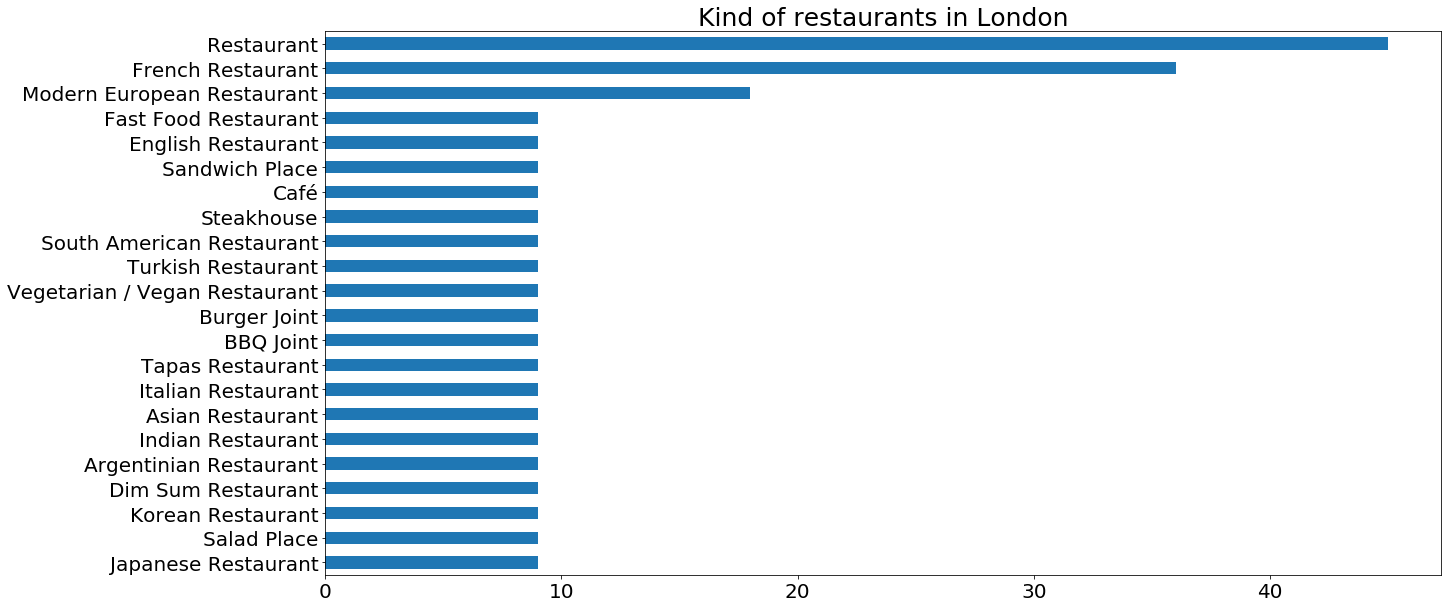

In [18]:
get_london_restaurants_kind = get_london_restaurants['Restaurant Category'].value_counts().iloc[::-1]
plt.figure()
get_london_restaurants_kind.plot.barh(figsize=(20,10), fontsize=20)
plt.title('Kind of restaurants in London', fontsize=25)

Text(0.5, 1.0, 'Kind of restaurants in Copenhagen')

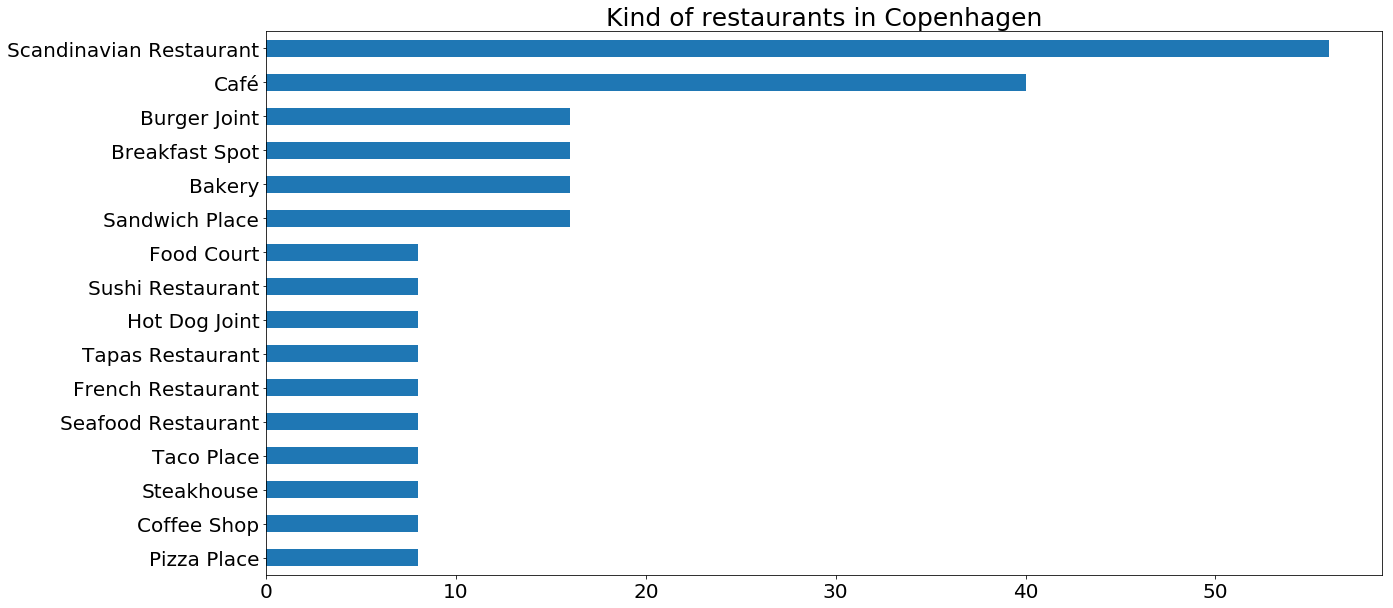

In [19]:
get_copenhagen_restaurants_kind = get_copenhagen_restaurants['Restaurant Category'].value_counts().iloc[::-1]
plt.figure()
get_copenhagen_restaurants_kind.plot.barh(figsize=(20,10), fontsize=20)
plt.title('Kind of restaurants in Copenhagen', fontsize=25)

Text(0.5, 1.0, 'Kind of restaurants in Vaduz')

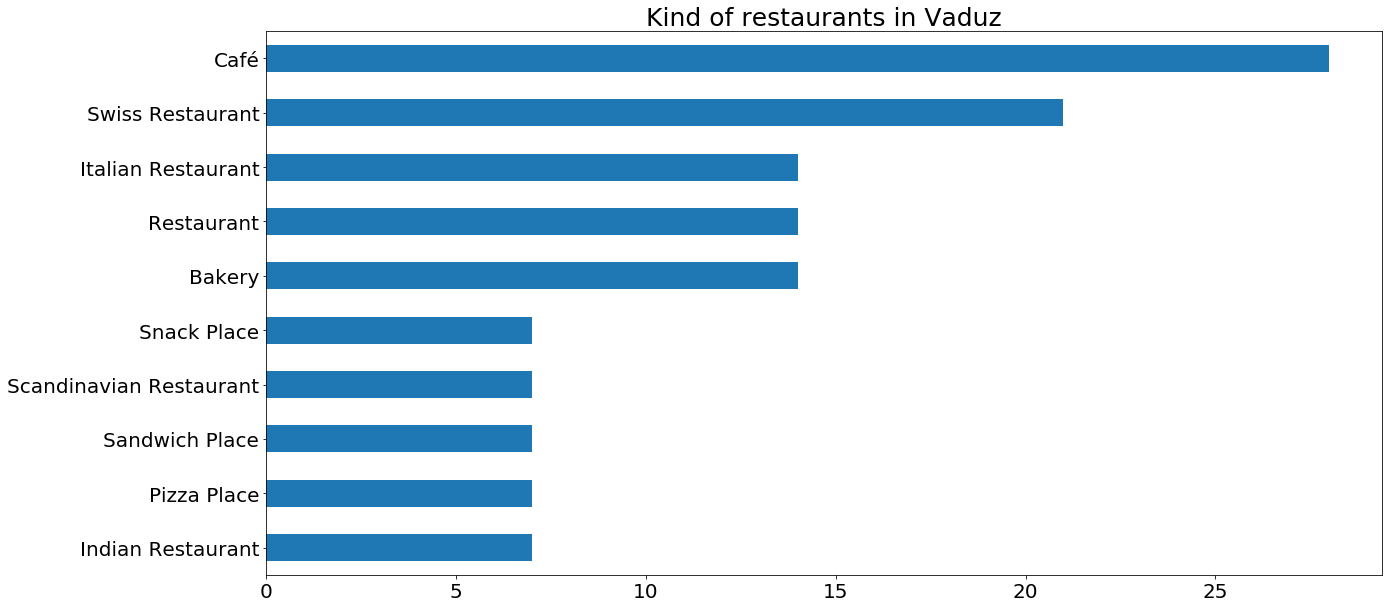

In [20]:
get_vaduz_restaurants_kind = get_vaduz_restaurants['Restaurant Category'].value_counts().iloc[::-1]
plt.figure()
get_vaduz_restaurants_kind.plot.barh(figsize=(20,10), fontsize=20)
plt.title('Kind of restaurants in Vaduz', fontsize=25)

## Results and Discussion

In [21]:
print('London city with the population of ' + london['population'] + ' people, and the ' + london['area'] + ' meters radius in the city centre.') 

London city with the population of 160160000 people, and the 707.3776509622841 meters radius in the city centre.


Has the most restaurants in our summary. London is much bigger, but as I said we are focusing only on the city centres.<br/>
Population of London is of course, the biggest. In order to satisfy this population, London was building a lot of all kinds restaurants.<br/>
As we can see we have choice with type of cuisine which is advantage of multi culture people.<br/>

In [22]:
print('Copenhagen city with the population of ' + copenhagen['population'] + ' people, and the ' + copenhagen['area'] + ' meters radius in the city centre.') 

Copenhagen city with the population of 777218000 people, and the 7536.947809847119 meters radius in the city centre.


Has a lot of all kind restaurants, food tracks and caffees, but in spite of bigger radius of city centre has less food places in the city than London.<br/>
In Copenhagen dominates other kind of food places than in London city centre. Dannish people prefer smaller food track places or cafess more than restaurants networks.

In [23]:
print('Vaduz city with the population of ' + vaduz['population'] + ' people, and the ' + vaduz['area'] + ' meters radius in the city centre.') 

Vaduz city with the population of 5521000 people, and the 2346.648893844066 meters radius in the city centre.


Vaduz is the smallest city. Radius include almost the city and the population is slightly lesser than other cities.<br/>
Amount of all kind food places is lower than in other cities in our comparison, but with some exceptions like Cafees.<br/>

## Conclusion

London has a lot of all kind of food places, everybody will find something for himself.<br/>
Londoners like eating in restaurants rather than Copenhagen and Vaduz citizens.<br/>
In order to succeed in british gastronomy you can relatively build restaurant with cuisine which can admire citizens.<br/>
But if you planning to move to Copenhagen you have to know that in Copenhagen city center are majority of different kinds of food tracks which sales very good in comparison to London city centre and Vaduz.<br/>
In smaller capital cities like Vaduz in Liechtenstein we are assuming that people prefer cooking at home or eating in work places, because 'light' kind of restaurants like caffees are dominating in summaries.<br/>
Wee can crearly see that there are different fancies of eating and drinking outside according to the place which we actually be.<br/>
This is the mostly correlated to culture in given country (we can see from lotitude and langitude that these cities are pretty far away from itselves), because mainly clients shape city gastronomy.